# 계절성 있는 시계열 분석으로 미래 매출 내다보기

In [ ]:

# 프로젝트명: 계절성 있는 시계열 분석으로 미래 월별 매출 내다보기
# 목표변수: revenue = item_cnt_day * item_price (월 합)
# 모델 비교:
#   1) Baseline (전월 / MA12)
#   2) SARIMAX (ARIMA 계열, 계절성 12)
#   3) ETS (Exponential Smoothing / Holt-Winters)
#   4) Deep Learning: iTransformer-like (Quantile Forecast)
#   5) Deep Learning: TimesNet (Quantile Forecast)

#  🧪 평가:
#   - Holdout Backtest(마지막 5개월) RMSE/SMAPE
#   - TimeSeries CV(Expanding Window) RMSE/SMAPE

#  결과물:
#   - 다음 5개월 매출 예측 + 불확실성(구간) + 리스크 분석

# NOTE:
# - ETS 예측구간은 잔차 기반 근사(간단 버전)로 구현

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# PyTorch (딥러닝)
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
except ImportError as e:
    raise ImportError(
        "PyTorch(torch)가 필요합니다. 예: pip install torch\n"
        "설치 후 다시 실행해주세요."
    ) from e

print("Imports OK")


Imports OK


In [5]:
# 재현성(실험 반복 시 결과가 크게 흔들리지 않게) 설정
def seed_everything(seed=2026):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cpu


In [6]:
# 데이터 로드
# Kaggle 1C Sales 데이터
# Kaggle 1C Sales 데이터는 Kaggle 대회 Predict Future Sales에서 쓰이는 리테일 시계열 데이터셋으로, 러시아 소프트웨어 기업 1C Company가 제공한 일별 판매 기록(daily sales data) 기반
# 목표는 과거 데이터를 이용해 다음 달(대회 기준: 2015년 11월)의 상점(shop)×상품(item) 조합별 판매량(월 합)을 예측하는 것

filepath = 'https://github.com/mchoimis/tsdl/raw/main/sales/'

sales = pd.read_csv(filepath + 'train.csv')
item_cat = pd.read_csv(filepath + 'item-category.csv')
item = pd.read_csv(filepath + 'items.csv')
shops = pd.read_csv(filepath + 'shops.csv')
test = pd.read_csv(filepath + 'test.csv')

# 날짜 파싱
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')

print(sales.info())
sales.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [ ]:
# 전처리
# price <= 0 제거
# 음수 수량(반품)은 0으로 클리핑
sales = sales[sales['item_price'] > 0].copy()
sales['item_cnt_day'] = sales['item_cnt_day'].clip(lower=0)

# 매출(revenue) = 수량 * 가격
sales['revenue'] = sales['item_cnt_day'] * sales['item_price']

# 월별(date_block_num) 집계
monthly = sales.groupby('date_block_num').agg(
    y_rev=('revenue', 'sum'),                # 월 매출 합(타겟)
    y_cnt=('item_cnt_day', 'sum'),           # 월 수량 합(참고)
    avg_price=('item_price', 'mean'),        # 월 평균 가격(보조지표)
    active_shops=('shop_id', 'nunique'),     # 활성 샵 수
    active_items=('item_id', 'nunique')      # 활성 아이템 수
).reset_index()

# ds(월초) 생성: 2013-01부터 월 단위
monthly['ds'] = pd.date_range(start='2013-01-01', periods=len(monthly), freq='MS')

# 분석에 쓸 컬럼만 유지
monthly = monthly[['ds', 'y_rev', 'y_cnt', 'avg_price', 'active_shops', 'active_items']].copy()

print("Months:", len(monthly))
display(monthly.head())
display(monthly.tail())

Months: 34


,ds,y_rev,y_cnt,avg_price,active_shops,active_items
0,2013-01-01,9.239909e+07,131850.0,710.622127,45,8115
1,2013-02-01,9.096449e+07,128382.0,695.866856,46,8168
2,2013-03-01,1.052654e+08,147438.0,694.688063,46,8302
3,2013-04-01,6.945713e+07,107439.0,653.633797,46,8145
4,2013-05-01,6.525317e+07,107147.0,624.186806,45,8339


,ds,y_rev,y_cnt,avg_price,active_shops,active_items
29,2015-06-01,6.563130e+07,64237.0,1020.437533,43,5216
30,2015-07-01,5.968569e+07,63316.0,966.828390,43,5323
31,2015-08-01,6.193087e+07,66196.0,951.374139,42,5108
32,2015-09-01,9.318504e+07,72989.0,1167.502290,43,5085
33,2015-10-01,8.463016e+07,71184.0,1224.574825,44,5413


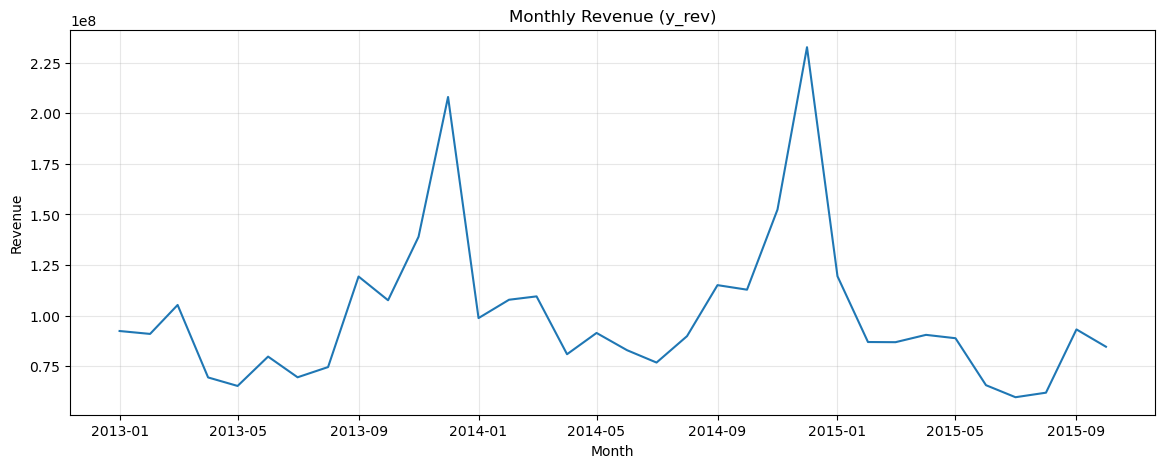

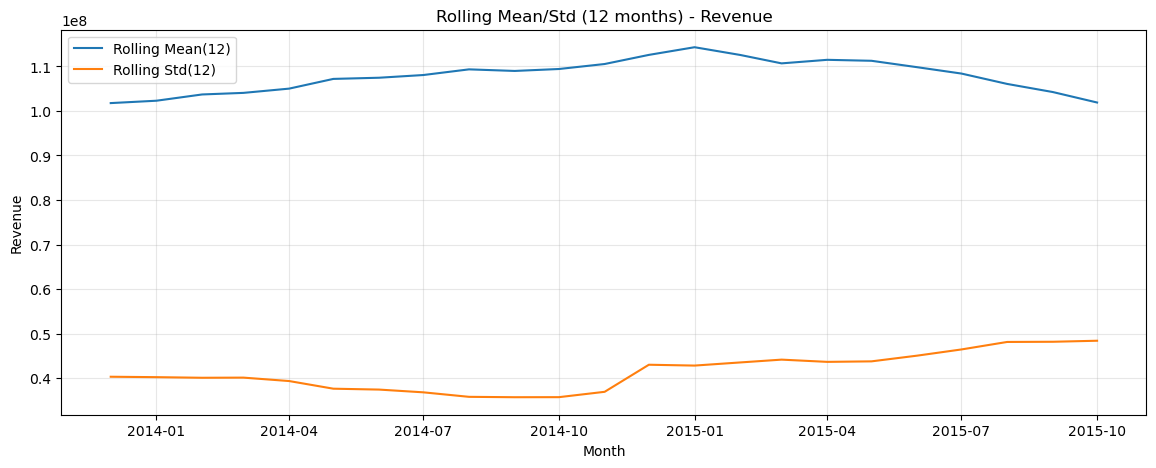

In [ ]:
# EDA: 월별 매출 추세/변동성 확인 > 시계열 시각화 📈

plt.figure(figsize=(14, 5))
plt.plot(monthly['ds'], monthly['y_rev'])
plt.title('Monthly Revenue (y_rev)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(monthly['ds'], monthly['y_rev'].rolling(12).mean(), label='Rolling Mean(12)')
plt.plot(monthly['ds'], monthly['y_rev'].rolling(12).std(), label='Rolling Std(12)')
plt.title('Rolling Mean/Std (12 months) - Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# 평가 지표 정의
# RMSE: 큰 오차에 민감
# SMAPE: 스케일에 덜 민감(비율 기반) 
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.maximum(denom, 1e-8)
    return float(np.mean(diff) * 100)


# Holdout Backtest 설정
# 마지막 5개월을 테스트로 두고 모델 성능 비교
HORIZON = 5
train_df = monthly.iloc[:-HORIZON].copy()
test_df  = monthly.iloc[-HORIZON:].copy()

y_train = train_df.set_index('ds')['y_rev']
y_test  = test_df.set_index('ds')['y_rev']

print("[Backtest period]")
print("Train:", train_df['ds'].min(), "to", train_df['ds'].max(), "len=", len(train_df))
print("Test :", test_df['ds'].min(), "to", test_df['ds'].max(), "len=", len(test_df))

[Backtest period]
Train: 2013-01-01 00:00:00 to 2015-05-01 00:00:00 len= 29
Test : 2015-06-01 00:00:00 to 2015-10-01 00:00:00 len= 5


In [10]:
# Baseline 모델
# 전월값 유지(naive)
# 최근 12개월 평균(MA12)

last_value = y_train.iloc[-1]
ma12_value = y_train.tail(12).mean()

test_df['pred_baseline_last'] = last_value
test_df['pred_baseline_ma12'] = ma12_value

print("[Backtest - Baselines]")
print("Baseline(last month) RMSE :", rmse(test_df['y_rev'], test_df['pred_baseline_last']))
print("Baseline(last month) SMAPE:", smape(test_df['y_rev'], test_df['pred_baseline_last']))
print("Baseline(MA12)       RMSE :", rmse(test_df['y_rev'], test_df['pred_baseline_ma12']))
print("Baseline(MA12)       SMAPE:", smape(test_df['y_rev'], test_df['pred_baseline_ma12']))

[Backtest - Baselines]
Baseline(last month) RMSE : 20729307.026928082
Baseline(last month) SMAPE: 22.922823611094316
Baseline(MA12)       RMSE : 40525617.36852508
Baseline(MA12)       SMAPE: 42.75418679753898


In [11]:
# SARIMAX: 계절성(12개월)을 반영한 ARIMA 계열 모델
# 간단한 그리드에서 AIC 최소 모델 선택
# 95% 예측 구간(conf_int) 제공

SARIMAX_ORDERS = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]
SARIMAX_SEASONAL = [(1, 1, 1, 12), (0, 1, 1, 12), (1, 1, 0, 12)]

def select_sarimax_by_aic(y_series):
    best_aic = np.inf
    best_cfg = None
    best_model = None

    for order in SARIMAX_ORDERS:
        for sorder in SARIMAX_SEASONAL:
            try:
                model = SARIMAX(
                    y_series,
                    order=order,
                    seasonal_order=sorder,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                if model.aic < best_aic:
                    best_aic = model.aic
                    best_cfg = (order, sorder)
                    best_model = model
            except Exception:
                continue

    return best_model, best_cfg, best_aic

sar_model, sar_cfg, sar_aic = select_sarimax_by_aic(y_train)

print("[SARIMAX selection]")
print("Best config:", sar_cfg, "AIC:", sar_aic)

sar_forecast_res = sar_model.get_forecast(steps=HORIZON)
sar_pred = sar_forecast_res.predicted_mean
sar_ci = sar_forecast_res.conf_int(alpha=0.05)

test_df['pred_sarimax'] = sar_pred.values
test_df['pred_sarimax_lower'] = sar_ci.iloc[:, 0].values
test_df['pred_sarimax_upper'] = sar_ci.iloc[:, 1].values

print("[Backtest - SARIMAX]")
print("SARIMAX RMSE :", rmse(test_df['y_rev'], test_df['pred_sarimax']))
print("SARIMAX SMAPE:", smape(test_df['y_rev'], test_df['pred_sarimax']))


[SARIMAX selection]
Best config: ((1, 1, 2), (0, 1, 1, 12)) AIC: 45.25387567668923
[Backtest - SARIMAX]
SARIMAX RMSE : 1523168380.8948097
SARIMAX SMAPE: 163.6425428533166


In [12]:
# ETS(Holt-Winters Exponential Smoothing)
# trend/seasonal 조합을 후보로 두고 score(aic or sse) 최소 선택
# 예측구간은 잔차표준편차 기반으로 근사(간단 버전)

ETS_CONFIGS = [
    ('add', 'add'),
    ('add', None),
    (None, 'add'),
    (None, None),
    ('add', 'mul'),
    (None, 'mul'),
]

def fit_ets_select(train_series, seasonal_periods=12):
    best_score = np.inf
    best_cfg = None
    best_fit = None

    for trend, seasonal in ETS_CONFIGS:
        try:
            model = ExponentialSmoothing(
                train_series,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                initialization_method="estimated"
            )
            fit = model.fit(optimized=True, use_brute=True)

            score = getattr(fit, "aic", np.nan)
            if score is None or (isinstance(score, float) and np.isnan(score)):
                score = fit.sse

            if score < best_score:
                best_score = score
                best_cfg = (trend, seasonal)
                best_fit = fit
        except Exception:
            continue

    return best_fit, best_cfg, best_score

ets_fit, ets_cfg, ets_score = fit_ets_select(y_train, seasonal_periods=12)

print("[ETS selection]")
print("Best config:", ets_cfg, "score(aic or sse):", ets_score)

# 예측 + 간단 구간(근사)
ets_forecast = ets_fit.forecast(HORIZON).values
ets_fitted = ets_fit.fittedvalues
ets_resid = (y_train.values - ets_fitted.values)

ets_sigma = np.std(ets_resid, ddof=1) if len(ets_resid) > 2 else np.std(ets_resid)
h = np.arange(1, HORIZON + 1)
ets_margin = 1.96 * ets_sigma * np.sqrt(h)

test_df['pred_ets'] = ets_forecast
test_df['pred_ets_lower'] = ets_forecast - ets_margin
test_df['pred_ets_upper'] = ets_forecast + ets_margin

print("[Backtest - ETS]")
print("ETS RMSE :", rmse(test_df['y_rev'], test_df['pred_ets']))
print("ETS SMAPE:", smape(test_df['y_rev'], test_df['pred_ets']))


[ETS selection]
Best config: (None, 'add') score(aic or sse): 966.503970301867
[Backtest - ETS]
ETS RMSE : 23238082.771834023
ETS SMAPE: 26.59358158665691


In [13]:
# Deep Learning 모델들 공통 유틸
# Quantile Forecast: q05 / q50 / q95
# WindowDataset: (lookback -> horizon) 슬라이딩 윈도우 생성

FEATURE_COLS = ['y_rev', 'avg_price', 'active_shops', 'active_items']  # NOTE: y_rev가 반드시 첫 번째
LOOKBACK = 12
DL_BATCH = 16
DL_EPOCHS = 400
DL_LR = 1e-3
DL_PATIENCE = 40

def quantile_loss(pred, target, q: float):
    e = target - pred
    return torch.max((q - 1) * e, q * e).mean()

class WindowDataset(Dataset):
    def __init__(self, data_array, target_index, lookback, horizon):
        self.X = []
        self.y = []
        T = data_array.shape[0]
        for t in range(lookback, T - horizon + 1):
            self.X.append(data_array[t - lookback:t, :])       # (L, C)
            self.y.append(data_array[t:t + horizon, target_index])  # (H,)
        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_quantile_model(model, train_array, target_index, lookback, horizon,
                         batch_size=16, epochs=300, lr=1e-3, patience=30, verbose=False):
    ds = WindowDataset(train_array, target_index, lookback, horizon)
    if len(ds) < 3:
        raise ValueError(f"학습 윈도우 수가 너무 적습니다. windows={len(ds)} (lookback/horizon 줄이세요)")

    n = len(ds)
    n_val = max(1, int(n * 0.2))
    n_tr = n - n_val

    X_all, y_all = ds.X, ds.y
    X_tr, y_tr = X_all[:n_tr], y_all[:n_tr]
    X_va, y_va = X_all[n_tr:], y_all[n_tr:]

    tr_loader = DataLoader(list(zip(X_tr, y_tr)), batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(list(zip(X_va, y_va)), batch_size=batch_size, shuffle=False)

    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = np.inf
    best_state = None
    bad = 0

    for ep in range(1, epochs + 1):
        # --- train ---
        model.train()
        tr_losses = []

        for xb, yb in tr_loader:
            xb = torch.tensor(xb, device=DEVICE)
            yb = torch.tensor(yb, device=DEVICE)

            q05, q50, q95 = model(xb)
            loss = (quantile_loss(q05, yb, 0.05) +
                    quantile_loss(q50, yb, 0.50) +
                    quantile_loss(q95, yb, 0.95)) / 3.0

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_losses.append(loss.item())

        # --- val ---
        model.eval()
        va_losses = []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb = torch.tensor(xb, device=DEVICE)
                yb = torch.tensor(yb, device=DEVICE)
                q05, q50, q95 = model(xb)
                vloss = (quantile_loss(q05, yb, 0.05) +
                         quantile_loss(q50, yb, 0.50) +
                         quantile_loss(q95, yb, 0.95)) / 3.0
                va_losses.append(vloss.item())

        val_loss = float(np.mean(va_losses))
        if verbose and (ep % 50 == 0 or ep == 1):
            print(f"[DL] epoch={ep:4d} train_loss={np.mean(tr_losses):.6f} val_loss={val_loss:.6f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                if verbose:
                    print(f"[DL] Early stopping at epoch={ep}, best_val={best_val:.6f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict_quantile_model(model, input_window):
    model.eval()
    with torch.no_grad():
        xb = torch.tensor(input_window, dtype=torch.float32, device=DEVICE)
        q05, q50, q95 = model(xb)
        return (
            q05.squeeze(0).detach().cpu().numpy(),
            q50.squeeze(0).detach().cpu().numpy(),
            q95.squeeze(0).detach().cpu().numpy()
        )


In [14]:
# iTransformer 간단 구현 모델
# 입력 (B, L, C) -> invert (B, C, L)
# 각 변수(token)를 Linear(L -> d_model)로 임베딩
# TransformerEncoder를 "변수 토큰 축"으로 수행
# 타겟 토큰(y_rev)로 horizon 예측

class iTransformerLike(nn.Module):
    def __init__(self, lookback, n_vars, d_model=64, n_heads=4, n_layers=2, dropout=0.1, horizon=5):
        super().__init__()
        self.token_embed = nn.Linear(lookback, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head_q05 = nn.Linear(d_model, horizon)
        self.head_q50 = nn.Linear(d_model, horizon)
        self.head_q95 = nn.Linear(d_model, horizon)

    def forward(self, x):
        x = x.permute(0, 2, 1)      # (B, C, L)
        tok = self.token_embed(x)   # (B, C, d_model)
        z = self.encoder(tok)       # (B, C, d_model)
        tgt = z[:, 0, :]            # channel 0 = y_rev
        return self.head_q05(tgt), self.head_q50(tgt), self.head_q95(tgt)

# 스케일링 (train 기준)
scaler_i = StandardScaler()
train_scaled_i = scaler_i.fit_transform(train_df[FEATURE_COLS].values)

itr_model = iTransformerLike(
    lookback=LOOKBACK, n_vars=len(FEATURE_COLS),
    d_model=64, n_heads=4, n_layers=2, dropout=0.1, horizon=HORIZON
)

itr_model = train_quantile_model(
    itr_model, train_array=train_scaled_i,
    target_index=0, lookback=LOOKBACK, horizon=HORIZON,
    batch_size=DL_BATCH, epochs=DL_EPOCHS, lr=DL_LR, patience=DL_PATIENCE,
    verbose=True
)

# test 구간 예측: train 마지막 LOOKBACK으로 1회(5개월)
last_window_i = train_scaled_i[-LOOKBACK:, :].reshape(1, LOOKBACK, -1)
q05_s, q50_s, q95_s = predict_quantile_model(itr_model, last_window_i)

mean_y_i = scaler_i.mean_[0]
std_y_i = np.sqrt(scaler_i.var_[0])

test_df['pred_itransformer'] = q50_s * std_y_i + mean_y_i
test_df['pred_itransformer_lower'] = q05_s * std_y_i + mean_y_i
test_df['pred_itransformer_upper'] = q95_s * std_y_i + mean_y_i

print("[Backtest - iTransformer-like]")
print("RMSE :", rmse(test_df['y_rev'], test_df['pred_itransformer']))
print("SMAPE:", smape(test_df['y_rev'], test_df['pred_itransformer']))


[DL] epoch=   1 train_loss=0.403040 val_loss=0.348288
[DL] epoch=  50 train_loss=0.051987 val_loss=0.296592
[DL] Early stopping at epoch=63, best_val=0.265307
[Backtest - iTransformer-like]
RMSE : 23403952.232493047
SMAPE: 22.697276832982222


In [15]:
# TimesNet
# FFT로 주기 후보(period)를 추정
# period 기준으로 2D reshape 후 Conv2D(Inception-like)로 패턴 추출
# 여러 period 결과를 가중합 → residual + layernorm

class InceptionConv(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.c1 = nn.Conv2d(channels, channels, kernel_size=(1, 3), padding=(0, 1))
        self.c2 = nn.Conv2d(channels, channels, kernel_size=(3, 1), padding=(1, 0))
        self.c3 = nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=(1, 1))
        self.act = nn.GELU()

    def forward(self, x):
        return self.act(self.c1(x) + self.c2(x) + self.c3(x))

def topk_periods_from_fft(x_1d, top_k=3):
    L = len(x_1d)
    fft = np.fft.rfft(x_1d - np.mean(x_1d))
    amp = np.abs(fft)
    amp[0] = 0

    idx = np.argsort(amp)[::-1]
    periods, weights = [], []

    for k in idx[:top_k * 5]:
        if k <= 0:
            continue
        period = int(round(L / k))
        if period < 2 or period > L:
            continue
        if period not in periods:
            periods.append(period)
            weights.append(float(amp[k]))
        if len(periods) >= top_k:
            break

    if len(periods) == 0:
        periods = [max(2, L // 2)]
        weights = [1.0]

    weights = np.array(weights, dtype=float)
    weights = weights / (weights.sum() + 1e-8)
    return periods, weights.tolist()

class TimesBlock(nn.Module):
    def __init__(self, d_model, top_k=3):
        super().__init__()
        self.top_k = top_k
        self.incept = InceptionConv(d_model)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x):
        B, L, D = x.shape
        x_np = x[:, :, 0].detach().mean(dim=0).cpu().numpy()
        periods, weights = topk_periods_from_fft(x_np, top_k=self.top_k)

        agg = torch.zeros_like(x)

        for period, w in zip(periods, weights):
            pad_len = (period - (L % period)) % period
            if pad_len > 0:
                pad = torch.zeros((B, pad_len, D), device=x.device, dtype=x.dtype)
                x_pad = torch.cat([x, pad], dim=1)
            else:
                x_pad = x

            Lp = x_pad.shape[1]
            n = Lp // period

            x2 = x_pad.permute(0, 2, 1).reshape(B, D, n, period)
            y2 = self.incept(x2)
            y = y2.reshape(B, D, Lp).permute(0, 2, 1)
            y = y[:, :L, :]

            agg = agg + (w * y)

        return self.ln(x + agg)

class TimesNet(nn.Module):
    def __init__(self, n_vars, d_model=64, n_blocks=2, top_k=3, horizon=5, dropout=0.1):
        super().__init__()
        self.value_embed = nn.Linear(n_vars, d_model)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TimesBlock(d_model, top_k=top_k) for _ in range(n_blocks)])

        self.head_q05 = nn.Linear(d_model, horizon)
        self.head_q50 = nn.Linear(d_model, horizon)
        self.head_q95 = nn.Linear(d_model, horizon)

    def forward(self, x):
        z = self.drop(self.value_embed(x))  # (B, L, D)
        for blk in self.blocks:
            z = blk(z)
        last = z[:, -1, :]
        return self.head_q05(last), self.head_q50(last), self.head_q95(last)


In [16]:
# TimesNet: train -> test 예측

scaler_t = StandardScaler()
train_scaled_t = scaler_t.fit_transform(train_df[FEATURE_COLS].values)

times_model = TimesNet(
    n_vars=len(FEATURE_COLS), d_model=64, n_blocks=2, top_k=3,
    horizon=HORIZON, dropout=0.1
)

times_model = train_quantile_model(
    times_model, train_array=train_scaled_t,
    target_index=0, lookback=LOOKBACK, horizon=HORIZON,
    batch_size=DL_BATCH, epochs=DL_EPOCHS, lr=DL_LR, patience=DL_PATIENCE,
    verbose=True
)

last_window_t = train_scaled_t[-LOOKBACK:, :].reshape(1, LOOKBACK, -1)
q05_s, q50_s, q95_s = predict_quantile_model(times_model, last_window_t)

mean_y_t = scaler_t.mean_[0]
std_y_t = np.sqrt(scaler_t.var_[0])

test_df['pred_timesnet'] = q50_s * std_y_t + mean_y_t
test_df['pred_timesnet_lower'] = q05_s * std_y_t + mean_y_t
test_df['pred_timesnet_upper'] = q95_s * std_y_t + mean_y_t

print("[Backtest - TimesNet]")
print("RMSE :", rmse(test_df['y_rev'], test_df['pred_timesnet']))
print("SMAPE:", smape(test_df['y_rev'], test_df['pred_timesnet']))


[DL] epoch=   1 train_loss=0.444312 val_loss=0.391443
[DL] Early stopping at epoch=44, best_val=0.328303
[Backtest - TimesNet]
RMSE : 30052127.289075594
SMAPE: 32.38061060579363


In [17]:
# TimeSeries CV (Expanding Window)
# 딥러닝은 비용이 크므로 최근 max_folds개만 수행

INITIAL_TRAIN = 24
STEP = 1

def make_folds(df, initial_train=24, horizon=5, step=1):
    folds = []
    n = len(df)
    train_end = initial_train
    while train_end + horizon <= n:
        train_idx = list(range(0, train_end))
        test_idx = list(range(train_end, train_end + horizon))
        folds.append((train_idx, test_idx))
        train_end += step
    return folds

folds = make_folds(monthly, initial_train=INITIAL_TRAIN, horizon=HORIZON, step=STEP)
print(f"CV folds = {len(folds)}")

def cv_baselines(df, folds):
    rmses_last, smapes_last = [], []
    rmses_ma12, smapes_ma12 = [], []

    for tr_idx, te_idx in folds:
        tr = df.iloc[tr_idx]
        te = df.iloc[te_idx]
        y_tr = tr['y_rev'].values
        y_te = te['y_rev'].values

        pred_last = np.repeat(y_tr[-1], len(te))
        pred_ma12 = np.repeat(np.mean(y_tr[-12:]) if len(y_tr) >= 12 else np.mean(y_tr), len(te))

        rmses_last.append(rmse(y_te, pred_last))
        smapes_last.append(smape(y_te, pred_last))
        rmses_ma12.append(rmse(y_te, pred_ma12))
        smapes_ma12.append(smape(y_te, pred_ma12))

    return {
        'Baseline_LastMonth': {'RMSE': float(np.mean(rmses_last)), 'SMAPE': float(np.mean(smapes_last))},
        'Baseline_MA12': {'RMSE': float(np.mean(rmses_ma12)), 'SMAPE': float(np.mean(smapes_ma12))}
    }

def cv_sarimax(df, folds, order, seasonal_order):
    rmses, smapes = [], []
    for tr_idx, te_idx in folds:
        tr = df.iloc[tr_idx]
        te = df.iloc[te_idx]
        y_tr = tr.set_index('ds')['y_rev']
        y_te = te['y_rev'].values
        try:
            m = SARIMAX(
                y_tr, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            pred = m.get_forecast(steps=len(te)).predicted_mean.values
            rmses.append(rmse(y_te, pred))
            smapes.append(smape(y_te, pred))
        except Exception:
            rmses.append(np.nan)
            smapes.append(np.nan)

    return {'SARIMAX': {'RMSE': float(np.nanmean(rmses)), 'SMAPE': float(np.nanmean(smapes))}}

def cv_ets(df, folds):
    rmses, smapes = [], []
    for tr_idx, te_idx in folds:
        tr = df.iloc[tr_idx]
        te = df.iloc[te_idx]
        y_tr = tr.set_index('ds')['y_rev']
        y_te = te['y_rev'].values
        try:
            fit, cfg, score = fit_ets_select(y_tr, seasonal_periods=12)
            pred = fit.forecast(len(te)).values
            rmses.append(rmse(y_te, pred))
            smapes.append(smape(y_te, pred))
        except Exception:
            rmses.append(np.nan)
            smapes.append(np.nan)

    return {'ETS': {'RMSE': float(np.nanmean(rmses)), 'SMAPE': float(np.nanmean(smapes))}}

def cv_deep_model(df, folds, model_factory, model_name, lookback, horizon,
                  max_folds=5, epochs_cv=200, patience_cv=25):
    rmses, smapes = [], []
    use_folds = folds[-max_folds:] if len(folds) > max_folds else folds

    for tr_idx, te_idx in use_folds:
        tr = df.iloc[tr_idx]
        te = df.iloc[te_idx]

        sc = StandardScaler()
        tr_scaled = sc.fit_transform(tr[FEATURE_COLS].values)

        try:
            model = model_factory()
            model = train_quantile_model(
                model, train_array=tr_scaled,
                target_index=0, lookback=lookback, horizon=horizon,
                batch_size=DL_BATCH, epochs=epochs_cv, lr=DL_LR, patience=patience_cv,
                verbose=False
            )

            win = tr_scaled[-lookback:, :].reshape(1, lookback, -1)
            _, q50_s, _ = predict_quantile_model(model, win)

            mean_y = sc.mean_[0]
            std_y = np.sqrt(sc.var_[0])
            pred = q50_s * std_y + mean_y

            y_true = te['y_rev'].values
            rmses.append(rmse(y_true, pred))
            smapes.append(smape(y_true, pred))
        except Exception:
            rmses.append(np.nan)
            smapes.append(np.nan)

    return {model_name: {'RMSE': float(np.nanmean(rmses)), 'SMAPE': float(np.nanmean(smapes))}}

# ---- CV 실행 ----
cv_result = {}
cv_result.update(cv_baselines(monthly, folds))

best_order, best_sorder = sar_cfg
cv_result.update(cv_sarimax(monthly, folds, best_order, best_sorder))
cv_result.update(cv_ets(monthly, folds))

cv_result.update(
    cv_deep_model(
        monthly, folds,
        model_factory=lambda: iTransformerLike(LOOKBACK, len(FEATURE_COLS), d_model=64, n_heads=4, n_layers=2, dropout=0.1, horizon=HORIZON),
        model_name='iTransformer_DL',
        lookback=LOOKBACK, horizon=HORIZON
    )
)

cv_result.update(
    cv_deep_model(
        monthly, folds,
        model_factory=lambda: TimesNet(len(FEATURE_COLS), d_model=64, n_blocks=2, top_k=3, horizon=HORIZON, dropout=0.1),
        model_name='TimesNet_DL',
        lookback=LOOKBACK, horizon=HORIZON
    )
)

cv_summary = pd.DataFrame(cv_result).T
display(cv_summary.sort_values('SMAPE'))


CV folds = 6


,RMSE,SMAPE
iTransformer_DL,1.944293e+07,20.077167
ETS,1.999417e+07,20.446535
Baseline_LastMonth,4.213966e+07,33.608053
Baseline_MA12,3.516311e+07,35.928147
TimesNet_DL,4.274816e+07,36.909751
SARIMAX,7.973368e+09,183.788712


In [18]:
# Holdout Backtest 결과 표

backtest_metrics = pd.DataFrame({
    'Model': [
        'Baseline_LastMonth',
        'Baseline_MA12',
        'SARIMAX',
        'ETS',
        'iTransformer_DL',
        'TimesNet_DL'
    ],
    'RMSE': [
        rmse(test_df['y_rev'], test_df['pred_baseline_last']),
        rmse(test_df['y_rev'], test_df['pred_baseline_ma12']),
        rmse(test_df['y_rev'], test_df['pred_sarimax']),
        rmse(test_df['y_rev'], test_df['pred_ets']),
        rmse(test_df['y_rev'], test_df['pred_itransformer']),
        rmse(test_df['y_rev'], test_df['pred_timesnet'])
    ],
    'SMAPE': [
        smape(test_df['y_rev'], test_df['pred_baseline_last']),
        smape(test_df['y_rev'], test_df['pred_baseline_ma12']),
        smape(test_df['y_rev'], test_df['pred_sarimax']),
        smape(test_df['y_rev'], test_df['pred_ets']),
        smape(test_df['y_rev'], test_df['pred_itransformer']),
        smape(test_df['y_rev'], test_df['pred_timesnet'])
    ]
}).sort_values('SMAPE')

display(backtest_metrics)

# -----------------------------
# CV 기준으로 베스트 모델 선택(SMAPE 최소)
# -----------------------------
cv_for_select = cv_summary.dropna(subset=['SMAPE']).copy()
best_model_name = cv_for_select['SMAPE'].idxmin()
print("Best model by CV SMAPE:", best_model_name)


,Model,RMSE,SMAPE
4,iTransformer_DL,2.340395e+07,22.697277
0,Baseline_LastMonth,2.072931e+07,22.922824
3,ETS,2.323808e+07,26.593582
5,TimesNet_DL,3.005213e+07,32.380611
1,Baseline_MA12,4.052562e+07,42.754187
2,SARIMAX,1.523168e+09,163.642543


Best model by CV SMAPE: iTransformer_DL


In [19]:
# 전체 데이터로 재학습 후 다음 5개월 예측
# 예측구간 제공(가능한 모델만)
# 리스크(Downside) 태그

FULL_HORIZON = 5
future_months = pd.date_range(
    start=monthly['ds'].max() + pd.offsets.MonthBegin(1),
    periods=FULL_HORIZON,
    freq='MS'
)

full_y = monthly.set_index('ds')['y_rev']
final_forecasts = {}

# --- Baselines ---
final_forecasts['Baseline_LastMonth'] = pd.DataFrame({
    'ds': future_months,
    'yhat': np.repeat(full_y.iloc[-1], FULL_HORIZON),
    'yhat_lower': np.repeat(np.nan, FULL_HORIZON),
    'yhat_upper': np.repeat(np.nan, FULL_HORIZON)
})

final_forecasts['Baseline_MA12'] = pd.DataFrame({
    'ds': future_months,
    'yhat': np.repeat(full_y.tail(12).mean(), FULL_HORIZON),
    'yhat_lower': np.repeat(np.nan, FULL_HORIZON),
    'yhat_upper': np.repeat(np.nan, FULL_HORIZON)
})

# --- SARIMAX ---
sar_full = SARIMAX(
    full_y, order=best_order, seasonal_order=best_sorder,
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False)

sar_full_res = sar_full.get_forecast(steps=FULL_HORIZON)
sar_full_pred = sar_full_res.predicted_mean.values
sar_full_ci = sar_full_res.conf_int(alpha=0.05).values

final_forecasts['SARIMAX'] = pd.DataFrame({
    'ds': future_months,
    'yhat': sar_full_pred,
    'yhat_lower': sar_full_ci[:, 0],
    'yhat_upper': sar_full_ci[:, 1]
})

# --- ETS ---
ets_full_fit, ets_full_cfg, ets_full_score = fit_ets_select(full_y, seasonal_periods=12)
ets_full_forecast = ets_full_fit.forecast(FULL_HORIZON).values

ets_full_fitted = ets_full_fit.fittedvalues
ets_full_resid = (full_y.values - ets_full_fitted.values)
ets_full_sigma = np.std(ets_full_resid, ddof=1) if len(ets_full_resid) > 2 else np.std(ets_full_resid)

h = np.arange(1, FULL_HORIZON + 1)
ets_full_margin = 1.96 * ets_full_sigma * np.sqrt(h)

final_forecasts['ETS'] = pd.DataFrame({
    'ds': future_months,
    'yhat': ets_full_forecast,
    'yhat_lower': ets_full_forecast - ets_full_margin,
    'yhat_upper': ets_full_forecast + ets_full_margin
})

# --- iTransformer ---
sc_full_i = StandardScaler()
full_scaled_i = sc_full_i.fit_transform(monthly[FEATURE_COLS].values)

itr_full_model = iTransformerLike(
    lookback=LOOKBACK, n_vars=len(FEATURE_COLS),
    d_model=64, n_heads=4, n_layers=2, dropout=0.1, horizon=FULL_HORIZON
)

itr_full_model = train_quantile_model(
    itr_full_model, train_array=full_scaled_i,
    target_index=0, lookback=LOOKBACK, horizon=FULL_HORIZON,
    batch_size=DL_BATCH, epochs=DL_EPOCHS, lr=DL_LR, patience=DL_PATIENCE,
    verbose=True
)

full_last_window_i = full_scaled_i[-LOOKBACK:, :].reshape(1, LOOKBACK, -1)
q05_s, q50_s, q95_s = predict_quantile_model(itr_full_model, full_last_window_i)

mean_y = sc_full_i.mean_[0]
std_y = np.sqrt(sc_full_i.var_[0])

final_forecasts['iTransformer_DL'] = pd.DataFrame({
    'ds': future_months,
    'yhat': q50_s * std_y + mean_y,
    'yhat_lower': q05_s * std_y + mean_y,
    'yhat_upper': q95_s * std_y + mean_y
})

# --- TimesNet ---
sc_full_t = StandardScaler()
full_scaled_t = sc_full_t.fit_transform(monthly[FEATURE_COLS].values)

times_full_model = TimesNet(
    n_vars=len(FEATURE_COLS), d_model=64, n_blocks=2, top_k=3,
    horizon=FULL_HORIZON, dropout=0.1
)

times_full_model = train_quantile_model(
    times_full_model, train_array=full_scaled_t,
    target_index=0, lookback=LOOKBACK, horizon=FULL_HORIZON,
    batch_size=DL_BATCH, epochs=DL_EPOCHS, lr=DL_LR, patience=DL_PATIENCE,
    verbose=True
)

full_last_window_t = full_scaled_t[-LOOKBACK:, :].reshape(1, LOOKBACK, -1)
q05_s, q50_s, q95_s = predict_quantile_model(times_full_model, full_last_window_t)

mean_y = sc_full_t.mean_[0]
std_y = np.sqrt(sc_full_t.var_[0])

final_forecasts['TimesNet_DL'] = pd.DataFrame({
    'ds': future_months,
    'yhat': q50_s * std_y + mean_y,
    'yhat_lower': q05_s * std_y + mean_y,
    'yhat_upper': q95_s * std_y + mean_y
})

# --- 리스크 분석 ---
baseline_ref = full_y.tail(12).mean()

def risk_tag(lower, yhat, upper, ref):
    if np.isnan(lower) or np.isnan(upper):
        return "No-Interval"

    if lower < 0.9 * ref:
        base = "High downside risk"
    elif lower < ref:
        base = "Medium downside risk"
    else:
        base = "Low downside risk"

    if upper > 1.1 * ref:
        return base + " + Upside potential"
    return base

best_fcst = final_forecasts[best_model_name].copy()
best_fcst['ref_ma12'] = baseline_ref
best_fcst['risk'] = [risk_tag(l, y, u, baseline_ref)
                     for l, y, u in zip(best_fcst['yhat_lower'], best_fcst['yhat'], best_fcst['yhat_upper'])]

display(best_fcst)


[DL] epoch=   1 train_loss=0.411113 val_loss=0.375677
[DL] epoch=  50 train_loss=0.045841 val_loss=0.199305
[DL] Early stopping at epoch=79, best_val=0.175645
[DL] epoch=   1 train_loss=0.446487 val_loss=0.314657
[DL] epoch=  50 train_loss=0.083626 val_loss=0.194053
[DL] Early stopping at epoch=69, best_val=0.158425


,ds,yhat,yhat_lower,yhat_upper,ref_ma12,risk
0,2015-11-01,144824176.0,131053584.0,163288416.0,1.018930e+08,Low downside risk + Upside potential
1,2015-12-01,180485136.0,108705152.0,227473520.0,1.018930e+08,Low downside risk + Upside potential
2,2016-01-01,152174112.0,107027840.0,175399104.0,1.018930e+08,Low downside risk + Upside potential
3,2016-02-01,96168248.0,97098120.0,139269216.0,1.018930e+08,Medium downside risk + Upside potential
4,2016-03-01,91784808.0,83361960.0,148133600.0,1.018930e+08,High downside risk + Upside potential


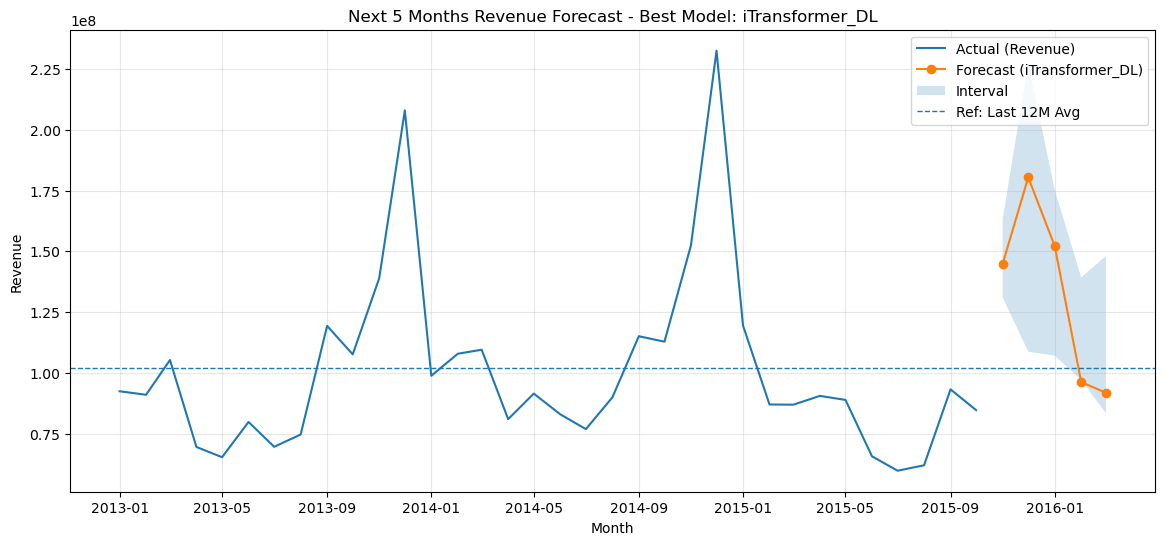

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(monthly['ds'], monthly['y_rev'], label='Actual (Revenue)')
plt.plot(best_fcst['ds'], best_fcst['yhat'], marker='o', label=f'Forecast ({best_model_name})')

if best_fcst['yhat_lower'].notna().any():
    plt.fill_between(best_fcst['ds'], best_fcst['yhat_lower'], best_fcst['yhat_upper'], alpha=0.2, label='Interval')

plt.axhline(baseline_ref, linestyle='--', linewidth=1, label='Ref: Last 12M Avg')
plt.title(f'Next {FULL_HORIZON} Months Revenue Forecast - Best Model: {best_model_name}')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


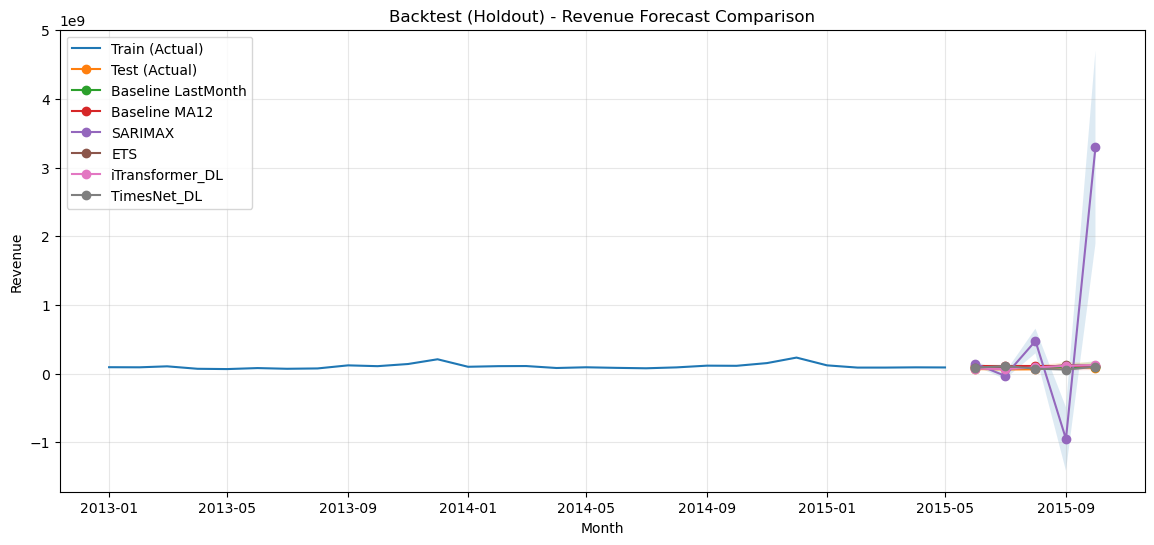

In [21]:
# Backtest 비교 그래프(테스트 5개월 구간)

plt.figure(figsize=(14, 6))
plt.plot(train_df['ds'], train_df['y_rev'], label='Train (Actual)')
plt.plot(test_df['ds'], test_df['y_rev'], marker='o', label='Test (Actual)')

plt.plot(test_df['ds'], test_df['pred_baseline_last'], marker='o', label='Baseline LastMonth')
plt.plot(test_df['ds'], test_df['pred_baseline_ma12'], marker='o', label='Baseline MA12')

plt.plot(test_df['ds'], test_df['pred_sarimax'], marker='o', label='SARIMAX')
plt.fill_between(test_df['ds'], test_df['pred_sarimax_lower'], test_df['pred_sarimax_upper'], alpha=0.15)

plt.plot(test_df['ds'], test_df['pred_ets'], marker='o', label='ETS')
plt.fill_between(test_df['ds'], test_df['pred_ets_lower'], test_df['pred_ets_upper'], alpha=0.15)

plt.plot(test_df['ds'], test_df['pred_itransformer'], marker='o', label='iTransformer_DL')
plt.fill_between(test_df['ds'], test_df['pred_itransformer_lower'], test_df['pred_itransformer_upper'], alpha=0.15)

plt.plot(test_df['ds'], test_df['pred_timesnet'], marker='o', label='TimesNet_DL')
plt.fill_between(test_df['ds'], test_df['pred_timesnet_lower'], test_df['pred_timesnet_upper'], alpha=0.15)

plt.title('Backtest (Holdout) - Revenue Forecast Comparison')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
print("\n========== SUMMARY ==========")
print("\n[Holdout Backtest Metrics]")
display(backtest_metrics)

print("\n[TimeSeries CV Metrics]")
display(cv_summary.sort_values('SMAPE'))

print("\n[Best Model by CV SMAPE]")
print(best_model_name)

print("\n[Best Model Forecast + Risk]")
display(best_fcst)

print("\n[All Models Forecast - Next 5 Months]")
for k, dfk in final_forecasts.items():
    print("\n---", k, "---")
    display(dfk)



========== SUMMARY ==========

[Holdout Backtest Metrics]


,Model,RMSE,SMAPE
4,iTransformer_DL,2.340395e+07,22.697277
0,Baseline_LastMonth,2.072931e+07,22.922824
3,ETS,2.323808e+07,26.593582
5,TimesNet_DL,3.005213e+07,32.380611
1,Baseline_MA12,4.052562e+07,42.754187
2,SARIMAX,1.523168e+09,163.642543



[TimeSeries CV Metrics]


,RMSE,SMAPE
iTransformer_DL,1.944293e+07,20.077167
ETS,1.999417e+07,20.446535
Baseline_LastMonth,4.213966e+07,33.608053
Baseline_MA12,3.516311e+07,35.928147
TimesNet_DL,4.274816e+07,36.909751
SARIMAX,7.973368e+09,183.788712



[Best Model by CV SMAPE]
iTransformer_DL

[Best Model Forecast + Risk]


,ds,yhat,yhat_lower,yhat_upper,ref_ma12,risk
0,2015-11-01,144824176.0,131053584.0,163288416.0,1.018930e+08,Low downside risk + Upside potential
1,2015-12-01,180485136.0,108705152.0,227473520.0,1.018930e+08,Low downside risk + Upside potential
2,2016-01-01,152174112.0,107027840.0,175399104.0,1.018930e+08,Low downside risk + Upside potential
3,2016-02-01,96168248.0,97098120.0,139269216.0,1.018930e+08,Medium downside risk + Upside potential
4,2016-03-01,91784808.0,83361960.0,148133600.0,1.018930e+08,High downside risk + Upside potential



[All Models Forecast - Next 5 Months]

--- Baseline_LastMonth ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,84630164.06,NaN,NaN
1,2015-12-01,84630164.06,NaN,NaN
2,2016-01-01,84630164.06,NaN,NaN
3,2016-02-01,84630164.06,NaN,NaN
4,2016-03-01,84630164.06,NaN,NaN



--- Baseline_MA12 ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,1.018930e+08,NaN,NaN
1,2015-12-01,1.018930e+08,NaN,NaN
2,2016-01-01,1.018930e+08,NaN,NaN
3,2016-02-01,1.018930e+08,NaN,NaN
4,2016-03-01,1.018930e+08,NaN,NaN



--- SARIMAX ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,1.124422e+08,7.949154e+07,1.453929e+08
1,2015-12-01,1.724918e+08,1.277470e+08,2.172365e+08
2,2016-01-01,1.001026e+08,4.885418e+07,1.513510e+08
3,2016-02-01,8.394130e+07,2.577817e+07,1.421044e+08
4,2016-03-01,8.668048e+07,2.284590e+07,1.505151e+08



--- ETS ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,1.114490e+08,9.004023e+07,1.328578e+08
1,2015-12-01,1.649418e+08,1.346652e+08,1.952185e+08
2,2016-01-01,7.800467e+07,4.092352e+07,1.150858e+08
3,2016-02-01,8.442119e+07,4.160357e+07,1.272388e+08
4,2016-03-01,8.536100e+07,3.748945e+07,1.332326e+08



--- iTransformer_DL ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,144824176.0,131053584.0,163288416.0
1,2015-12-01,180485136.0,108705152.0,227473520.0
2,2016-01-01,152174112.0,107027840.0,175399104.0
3,2016-02-01,96168248.0,97098120.0,139269216.0
4,2016-03-01,91784808.0,83361960.0,148133600.0



--- TimesNet_DL ---


,ds,yhat,yhat_lower,yhat_upper
0,2015-11-01,85402032.0,89270480.0,111932856.0
1,2015-12-01,91846080.0,58717344.0,133072864.0
2,2016-01-01,61766844.0,80694432.0,92880104.0
3,2016-02-01,66641068.0,63916120.0,62250036.0
4,2016-03-01,43746792.0,48454992.0,55006604.0
